# ImprovedLeNet5 with Advanced Techniques

Bu notebook, ödevde belirtilen geliştirmeleri (GELU, OneCycleLR, ColorJitter, RandomErasing, Label Smoothing, Checkpoint & Early Stopping) içeren ImprovedLeNet5 modelini oluşturup eğitir.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## 1. Data Preparation and Augmentation (Augmentation)

In [7]:
# Eğitim için güçlü veri artırma teknikleri
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    
    # Önce PIL Image'ı Tensor’a çevir
    transforms.ToTensor(),
    
    # Artık tensor üzerinden RandomErasing çalıştır
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.2)),
    
    # Normalize
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Doğrulama ve test için sadece normalize
transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 veri setlerini yükleme
train_full   = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True,  transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,  transform=transform_eval)

# %80 train / %20 validation split
num_train     = len(train_full)
split         = int(0.8 * num_train)
train_dataset = torch.utils.data.Subset(train_full, list(range(split)))
val_dataset   = torch.utils.data.Subset(train_full, list(range(split, num_train)))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=2)


## 2. Model Definition (CNN-only, GELU)

In [8]:
class ImprovedLeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedLeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.GELU(), nn.MaxPool2d(2), nn.Dropout(0.2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.GELU(), nn.MaxPool2d(2), nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.GELU(), nn.MaxPool2d(2), nn.Dropout(0.4)
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(128, num_classes, kernel_size=1),
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), -1)

# Modeli oluştur
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedLeNet5(num_classes=10).to(device)

## 3. Training and Evaluation Functions

In [9]:
def train_one_epoch(model, loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total

## 4. Training Cycle, Checkpoint & Early Stopping

Epoch 1/30 - Train loss: 1.9315, Acc: 0.3269 - Val loss: 1.7988, Acc: 0.4045
Epoch 2/30 - Train loss: 1.7090, Acc: 0.4434 - Val loss: 1.6854, Acc: 0.4410
Epoch 3/30 - Train loss: 1.6193, Acc: 0.4902 - Val loss: 1.6055, Acc: 0.4915
Epoch 4/30 - Train loss: 1.5648, Acc: 0.5192 - Val loss: 1.5042, Acc: 0.5541
Epoch 5/30 - Train loss: 1.5193, Acc: 0.5449 - Val loss: 1.5335, Acc: 0.5284
Epoch 6/30 - Train loss: 1.4721, Acc: 0.5694 - Val loss: 1.5337, Acc: 0.5495
Epoch 7/30 - Train loss: 1.4351, Acc: 0.5870 - Val loss: 1.3796, Acc: 0.6079
Epoch 8/30 - Train loss: 1.4061, Acc: 0.6025 - Val loss: 1.3867, Acc: 0.6113
Epoch 9/30 - Train loss: 1.3814, Acc: 0.6179 - Val loss: 1.3226, Acc: 0.6513
Epoch 10/30 - Train loss: 1.3580, Acc: 0.6277 - Val loss: 1.2697, Acc: 0.6721
Epoch 11/30 - Train loss: 1.3329, Acc: 0.6409 - Val loss: 1.2868, Acc: 0.6594
Epoch 12/30 - Train loss: 1.3127, Acc: 0.6509 - Val loss: 1.2367, Acc: 0.6916
Epoch 13/30 - Train loss: 1.2990, Acc: 0.6600 - Val loss: 1.3422, Acc: 0.

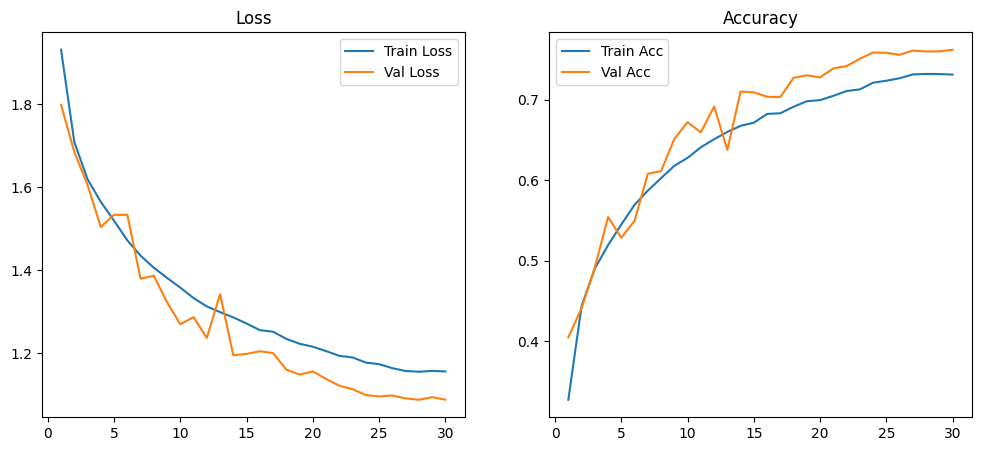

In [10]:
# Kayıp fonksiyonu, optimizer, scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
num_epochs = 30
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=len(train_loader), epochs=num_epochs)

# Early stopping ve checkpoint için değişkenler
best_val_loss = float('inf')
patience, no_improve = 5, 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} - Train loss: {train_loss:.4f}, Acc: {train_acc:.4f} - Val loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Checkpoint & early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"No improvement in {patience} epochs. Early stopping.")
            break

# En iyi modeli yükleyip test et
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Sonuçları grafikle
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()